# Mushroom Classification - Data Preprocessing and Model Training
***

### Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('mushrooms.csv')
df = df.drop(columns='veil-type') 
df.shape

(8124, 22)

In [3]:
df.columns

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-color', 'ring-number', 'ring-type',
       'spore-print-color', 'population', 'habitat'],
      dtype='object')

In [4]:
X=df.iloc[:,1:].to_numpy() #Features
y=df.iloc[:,0].to_numpy() #Target

In [5]:
X.shape

(8124, 21)

In [6]:
y.shape

(8124,)

In [7]:
X

array([['x', 's', 'n', ..., 'k', 's', 'u'],
       ['x', 's', 'y', ..., 'n', 'n', 'g'],
       ['b', 's', 'w', ..., 'n', 'n', 'm'],
       ...,
       ['f', 's', 'n', ..., 'b', 'c', 'l'],
       ['k', 'y', 'n', ..., 'w', 'v', 'l'],
       ['x', 's', 'n', ..., 'o', 'c', 'l']], dtype=object)

In [8]:
y

array(['p', 'e', 'e', ..., 'e', 'p', 'e'], dtype=object)

In [9]:
#Label Encoder and One hot encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

#One hot encoding our features using Column Transformer (applies one-hot encoding to all columns)
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse_output=False), list(range(X.shape[1])))], remainder='passthrough')
X = ct.fit_transform(X)

y = LabelEncoder().fit_transform(y)

In [10]:
print("Shape after encoding:", X.shape) #One-hot encoding creates a new column for each category of a feature

Shape after encoding: (8124, 116)


In [11]:
X

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
y

array([1, 0, 0, ..., 0, 1, 0])

In [13]:
print(np.unique(y)) #Ensure our target is 1 or 0

[0 1]


In [14]:
X.shape[0] == y.shape[0] #Ensure the rows match 

True

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

#Provides train/test indices to split data in train/test sets
#Split dataset into 5 consecutive folds, 4 parts are used for training, and 1 part is used for testing
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#Inspect the kfold cross validation split
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i}: ")
    print(f" Train:index={train_index}")
    print(f" Test:index={test_index}")
    

Fold 0: 
 Train:index=[   0    1    2 ... 8121 8122 8123]
 Test:index=[  17   19   23 ... 8113 8117 8119]
Fold 1: 
 Train:index=[   1    2    3 ... 8121 8122 8123]
 Test:index=[   0    8   12 ... 8099 8103 8116]
Fold 2: 
 Train:index=[   0    1    2 ... 8119 8120 8122]
 Test:index=[   6   18   24 ... 8115 8121 8123]
Fold 3: 
 Train:index=[   0    3    4 ... 8119 8121 8123]
 Test:index=[   1    2    7 ... 8118 8120 8122]
Fold 4: 
 Train:index=[   0    1    2 ... 8121 8122 8123]
 Test:index=[   3    4    5 ... 8106 8108 8112]


In [16]:
print(len(train_index))
print(len(test_index))

6500
1624


In [17]:
#Lists for values across 5 repeats
rfc_all=[]
rfc_f1_all=[]
feature_importance_all=[]


for repeat in range(1): #Number of repeats, try one repeat first (5 models)
    print('repeat is', repeat)

    #Lists for values for each repeat
    test_score_all_rfc=[]
    test_score_all_rfc_f1=[]
    feature_importance=[]

    #Further split each fold into train and validation set
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        print ('batch is', i)
        train_index_shuffle=shuffle(train_index)
        sub_train_index=train_index_shuffle[:int(len(train_index)*0.875)] #87.5% training 
        sub_valid_index=train_index_shuffle[int(len(train_index)*0.875):] #12.5% validation used for hyperparam tuning
        
        #Labels
        train_feature=[X[i] for i in sub_train_index]
        train_label=[y[i] for i in sub_train_index] 

        valid_feature=[X[i] for i in sub_valid_index]
        valid_label=[y[i] for i in sub_valid_index] 

        test_feature=[X[i] for i in test_index]
        test_label=[y[i] for i in test_index]

        #Hyperparameter pools
        max_depth_pool=[5,10,15,20]
        n_estimators_pool=[10, 50, 100,200]
        
        best_valid_score=float('-inf')
        #Loop over hyperparameters
        for m in max_depth_pool:
            for n in n_estimators_pool:
                model=RandomForestClassifier(max_depth=m, n_estimators=n, random_state=42) 
                model.fit(train_feature, train_label) #Train model on training set
                valid_score=model.score(valid_feature, valid_label) #Evaluate model using valid set

                #Implement early stopping
                if valid_score>best_valid_score:
                    best_valid_score=valid_score 
                    
                    #Once the best hyperparameters are selected, we can now use test set
                    test_score=model.score(test_feature, np.array(test_label))
                    pred=model.predict(test_feature)
                    best_max_depth=m
                    best_n_estimators=n
                    best_model=model
        
        print('test score is', test_score)
        test_score_all_rfc.append(test_score)
        test_score_all_rfc_f1.append(f1_score(test_label, pred, average='weighted'))
        feature_importance.append(best_model.feature_importances_)
        print('f1 is', f1_score(test_label, pred, average='weighted'))
        print('best max_depth is', best_max_depth)
        print('best n_estimators is', best_n_estimators)
        print('')
                    
    print('mean accuracy in this repeat', np.mean(test_score_all_rfc))  
    print('f1 mean accuracy in this repeat', np.mean(test_score_all_rfc_f1))
    feature_importance_all.append(np.mean(feature_importance,0))
    print('----------------------------')
    print('')  
    
    rfc_all.append(np.mean(test_score_all_rfc))      
print('mean accuracy for all repeats', np.mean(rfc_all))



repeat is 0
batch is 0
test score is 1.0
f1 is 1.0
best max_depth is 10
best n_estimators is 10

batch is 1
test score is 1.0
f1 is 1.0
best max_depth is 10
best n_estimators is 10

batch is 2
test score is 1.0
f1 is 1.0
best max_depth is 10
best n_estimators is 10

batch is 3
test score is 1.0
f1 is 1.0
best max_depth is 10
best n_estimators is 50

batch is 4
test score is 1.0
f1 is 1.0
best max_depth is 10
best n_estimators is 10

mean accuracy in this repeat 1.0
f1 mean accuracy in this repeat 1.0
----------------------------

mean accuracy for all repeats 1.0


In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

con_matrix=confusion_matrix(test_label, pred)
print(con_matrix)

[[846   0]
 [  0 778]]


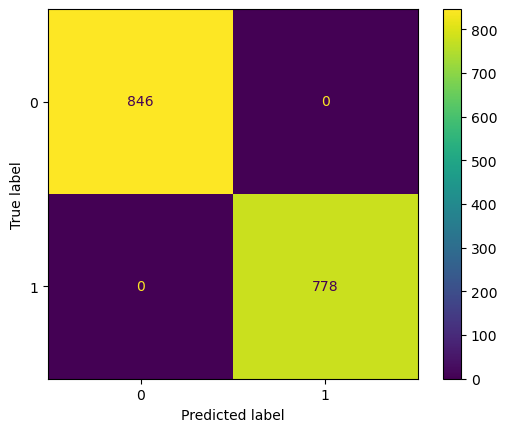

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
con_matrix_plot = ConfusionMatrixDisplay(confusion_matrix=con_matrix)
con_matrix_plot.plot()
plt.show()

In [20]:
from sklearn.metrics import classification_report

report = classification_report(test_label, pred)

with open("classification_report.txt", "w") as f:
    f.write(report)

print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       846
           1       1.00      1.00      1.00       778

    accuracy                           1.00      1624
   macro avg       1.00      1.00      1.00      1624
weighted avg       1.00      1.00      1.00      1624



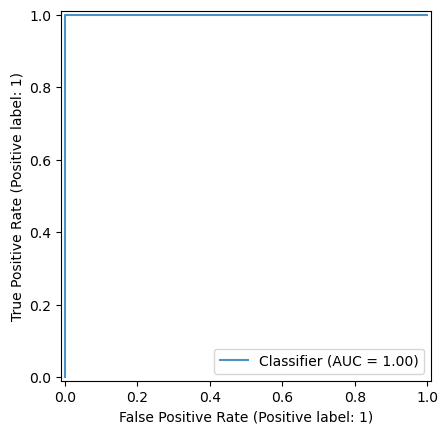

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

ax = plt.gca()
RocCurveDisplay.from_predictions(test_label, pred, ax=ax, alpha=0.8)
plt.show()

In [22]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

#Get the mean feature importance across folds
mean_feature_importance = np.mean(feature_importance_all, axis=0)

mean_feature_importance = mean_feature_importance.flatten()

#Get the one-hot encoded feature names
encoded_feature_names = ct.named_transformers_['encoder'].get_feature_names_out()

#Get the original feature names 
original_feature_names = df.drop(columns=['class']).columns.tolist()

#Create a mapping from encoded names to original features
feature_mapping = [original_feature_names[int(name.split('_')[0][1:])] for name in encoded_feature_names]

#Aggregate importance by original feature
importance_by_feature = defaultdict(float)

for orig_name, importance in zip(feature_mapping, mean_feature_importance):
    importance_by_feature[orig_name] += float(importance)  # ensure scalar

#Convert to sorted list
sorted_importance = sorted(importance_by_feature.items(), key=lambda x: x[1], reverse=True)

for feat, importance in sorted_importance:
    print(f"{feat}: {importance:.4f}")

odor: 0.2097
gill-size: 0.1437
stalk-surface-above-ring: 0.1313
spore-print-color: 0.0993
ring-type: 0.0931
gill-color: 0.0708
population: 0.0411
stalk-surface-below-ring: 0.0334
stalk-root: 0.0290
gill-spacing: 0.0279
habitat: 0.0208
bruises: 0.0196
stalk-shape: 0.0187
stalk-color-above-ring: 0.0173
ring-number: 0.0111
cap-color: 0.0103
cap-surface: 0.0099
stalk-color-below-ring: 0.0067
cap-shape: 0.0051
veil-color: 0.0008
gill-attachment: 0.0003


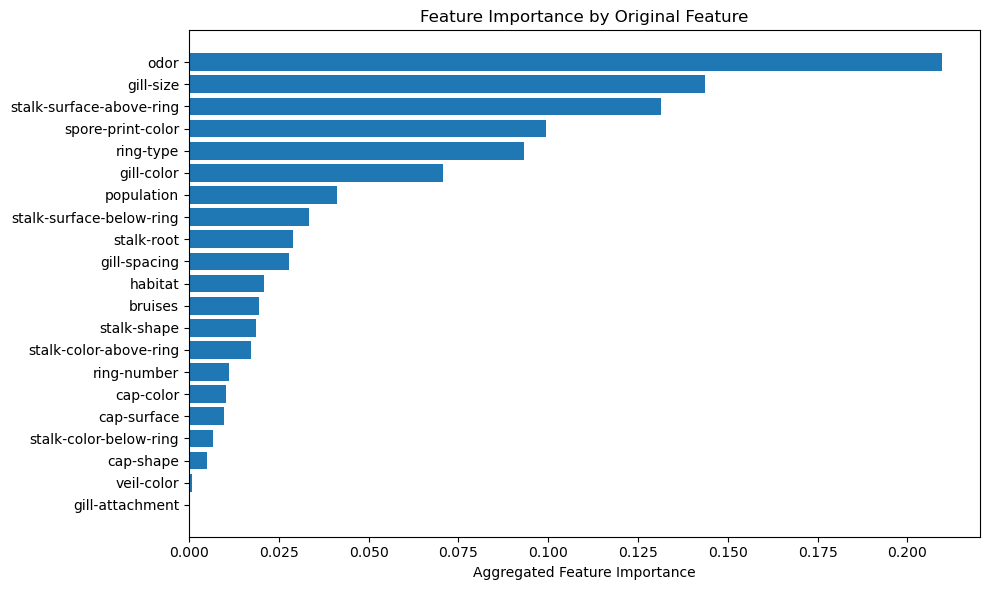

In [23]:
# Unzip for plotting
features, importances = zip(*sorted_importance)

plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel("Aggregated Feature Importance")
plt.title("Feature Importance by Original Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

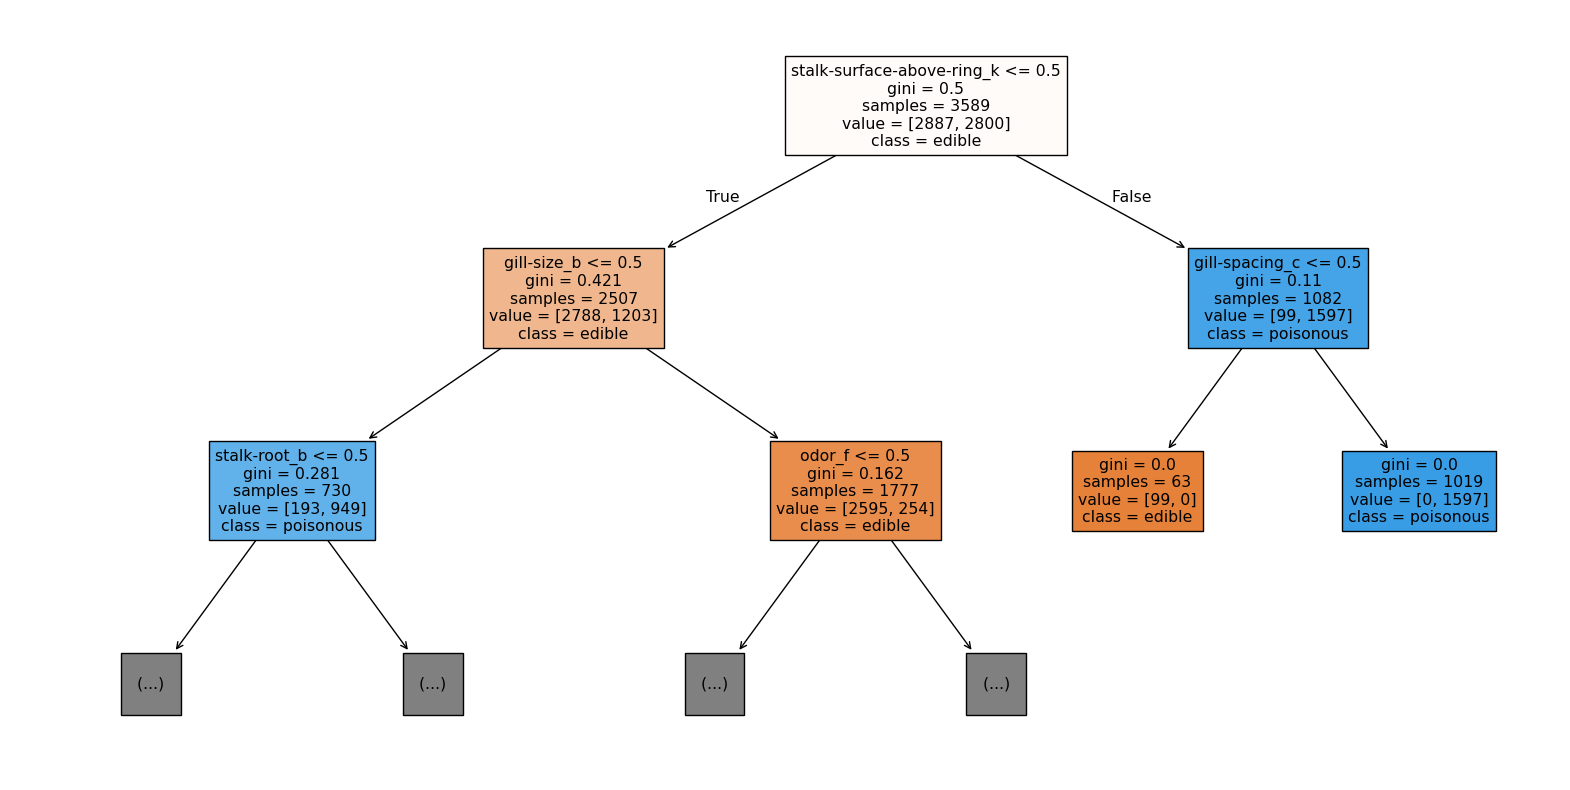

In [24]:
# Get original column names
of_name = df.drop(columns=['class']).columns.tolist()

#Get readable one-hot encoded feature names with original column names
ef_name = ct.named_transformers_['encoder'].get_feature_names_out(of_name)


#Plot a shallow tree with actual feature names
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(
    best_model.estimators_[0],
    feature_names=ef_name,
    filled=True,
    max_depth=2,
    class_names=['edible', 'poisonous']
)
plt.show()
